# KeyWordSpotting - LIVE DEMO

In [1]:
#Imports
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import Models #Our models
import LoadAndPreprocessDataset

categories=['yes','no','up','down','left','right','on','off','stop','go']
#categories=['yes','no','up','down','left','right','on','off','stop','go','zero','one','two','three','four','five','six','seven','eight','nine','unknown']


## 1) Audio Input
### Recording from microphone

In [22]:
sr = 16000
seconds = 10

myrec = sd.rec(int(sr*seconds), samplerate=sr, channels=1)
sd.wait()

np.save('LiveDemo/myrec2.npy', myrec)

### Reading it from a numpy array

In [ ]:
sr=16000
#myrec = np.load("LiveDemo/ONaudioclip.npy")
myrec = np.load("LiveDemo/myrec.npy")

### Reading it from a wav file

In [ ]:
myrec, sr = librosa.load("LiveDemo/audioclip.wav", sr=None)

### Audio Clip Informations

Sample rate =	16000 samples/s
Duration t =	10.0 s
Average intensity = 0.019799398


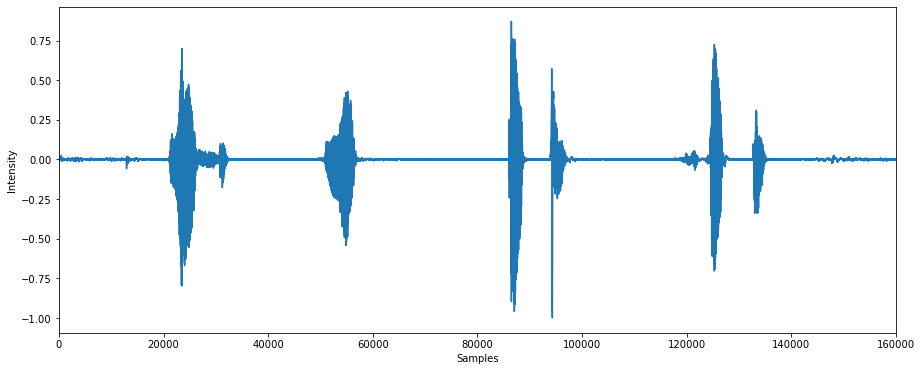

In [23]:
print("Sample rate =\t" + str(sr) + " samples/s")
print("Duration t =\t" + str(len(myrec) / sr) + " s")
print("Average intensity =",np.mean(np.abs(myrec)))

# Play it
play = False
if play:
    sd.play(myrec, sr)
    
# Plot
plt.figure(figsize=(15, 6))
plt.plot(myrec)
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(0, len(myrec))
plt.show()

## 2) Load Model

In [4]:
#Load Model
from tensorflow.keras.models import load_model
model_name="2020-07-25_13-50_DSConvModel"
model = load_model('models/'+model_name+'.h5')

## 3) Sliding Window
A 1 second window will slide left to right



In [24]:
###################### PARAMETERS ##########################################

ws=5 #windows per second >=2

#############################################################################

if len(myrec.shape)<2: myrec=myrec[...,np.newaxis] # for the 1 sec audios

step=int(sr/ws)
nwin=int((len(myrec)-sr)/step)+1 #number of windows
windows=np.empty((nwin,sr,1))
predictions=np.empty((nwin,1))

print("Number of windows:",nwin)
#print("Step:",step)
print("\n")
#print(windows.shape)
#print(predictions.shape)

#divide in windows
for i in range(nwin):
    start=int(i*step)
    end=int(start+sr)
    windows[i]=myrec[start:end]

    

#prediction speed measure
import time
sStarts=[]
sEnds=[]

for i in range(nwin):
    start=int(i*step)

    #SILENCE FILTER
    if np.mean(np.abs(windows[i]))<5*(10**-3):
        predictions[i]=-1 #Silence
        #plt.text(start+sr/4, 0, "SILENCE "+str(i), color='green')
        print("Window",i,"Silence")
    else:
        sStarts.append(time.time())
        
        a=windows[i]
        
        #preprocessing:         
        a=np.squeeze(a) #remove dimensions of length 1 (the last dimension)
        a=a[np.newaxis,...] #add dimension 1 at the beginning to indicate 1 example
        #a=LoadAndPreprocessDataset.MFCC(a,n_mfcc=40)
        a=LoadAndPreprocessDataset.melspect(a)
        a=a[...,np.newaxis] #add dimension 1 at the end for CNN
        
        #no preprocessing:
        #a=a[np.newaxis,...]
        
        predictions[i]=np.argmax(model.predict(a),1)
        
        p=categories[int(predictions[i])]
        #plt.text(start+sr/4, 0.1, "PRED "+str(i), color='blue')
        print("Window",i,p)
    
        sEnds.append(time.time())
    
#plt.show()


#Prediction Speed measure
elapseds=[]
for i in range(len(sStarts)):
    elapseds.append(sEnds[i]-sStarts[i])


print("\nAverage prediction speed per window (ms):",str(round(np.mean(elapseds)*1000,2)))
#print("Total elapsed time (ms):", str(round(np.mean(elapseds)*1000*len(elapseds),2)))



Number of windows: 46


Window 0 Silence
Window 1 Silence
Window 2 left
Window 3 yes
Window 4 yes
Window 5 yes
Window 6 yes
Window 7 yes
Window 8 up
Window 9 left
Window 10 Silence
Window 11 Silence
Window 12 left
Window 13 no
Window 14 no
Window 15 no
Window 16 no
Window 17 no
Window 18 Silence
Window 19 Silence
Window 20 Silence
Window 21 Silence
Window 22 Silence
Window 23 up
Window 24 up
Window 25 up
Window 26 up
Window 27 stop
Window 28 stop
Window 29 stop
Window 30 Silence
Window 31 Silence
Window 32 Silence
Window 33 Silence
Window 34 Silence
Window 35 stop
Window 36 stop
Window 37 stop
Window 38 go
Window 39 stop
Window 40 go
Window 41 left
Window 42 Silence
Window 43 Silence
Window 44 Silence
Window 45 Silence

Average prediction speed per window (ms): 70.86


### Fusion Rule

In [28]:
#majority
'''
DFA
         -1           any = No silence
         ↓ ↑   any   ↓ ↑
    --->(S1)--------->(S2)
          ↑            |
          --------------
                -1 = Silence
'''
newPredictions=[]
predictions=list(predictions)
predictions+=[-1]*ws #add silence at the end (will be removed later)

s1=True #true=s1, false=s2
i=0
start=0
while i<len(predictions):
    if s1: #state 1
        if predictions[i]!=-1: #not silence
            start=i
            s1=False
        else: #silence
            newPredictions.append(-1)
        i+=1
    else: #state 2
        if predictions[i]!=-1: #not silence
            pass
        else: #silence
            end=i
            a=predictions[start:end]
            #calculate most common number in the list
            ht={}
            freq=0
            most_freq=-1
            for e in a:
                e=int(e)
                if e in ht:
                    ht[e]+=1
                    if ht[e]>freq:
                        most_freq=e
                        freq=ht[e]
                else: ht[e]=0
            newPredictions=newPredictions+[most_freq]*(end-start)
            #append silence
            newPredictions.append(-1)
            s1=True
        i+=1
#print(newPredictions)

# remove the silence added before
del newPredictions[-ws:]

for i in range(len(newPredictions)):
    #if newPredictions[i]==-1: print(i,"Read:",predictions[i],newPredictions[i],"Silence")
    #else: print(i,"Read:",predictions[i],newPredictions[i],categories[newPredictions[i]])
    if newPredictions[i]==-1: print("Window",i,"Silence")
    else: print("Window",i,categories[newPredictions[i]])

Window 0 Silence
Window 1 Silence
Window 2 yes
Window 3 yes
Window 4 yes
Window 5 yes
Window 6 yes
Window 7 yes
Window 8 yes
Window 9 yes
Window 10 Silence
Window 11 Silence
Window 12 no
Window 13 no
Window 14 no
Window 15 no
Window 16 no
Window 17 no
Window 18 Silence
Window 19 Silence
Window 20 Silence
Window 21 Silence
Window 22 Silence
Window 23 up
Window 24 up
Window 25 up
Window 26 up
Window 27 up
Window 28 up
Window 29 up
Window 30 Silence
Window 31 Silence
Window 32 Silence
Window 33 Silence
Window 34 Silence
Window 35 stop
Window 36 stop
Window 37 stop
Window 38 stop
Window 39 stop
Window 40 stop
Window 41 stop
Window 42 Silence
Window 43 Silence
Window 44 Silence
Window 45 Silence
Window 46 Silence
Window 47 Silence
Window 48 Silence
Window 49 Silence
Window 50 Silence
Window 51 Silence
Window 52 Silence
Window 53 Silence
Window 54 Silence
Window 55 Silence


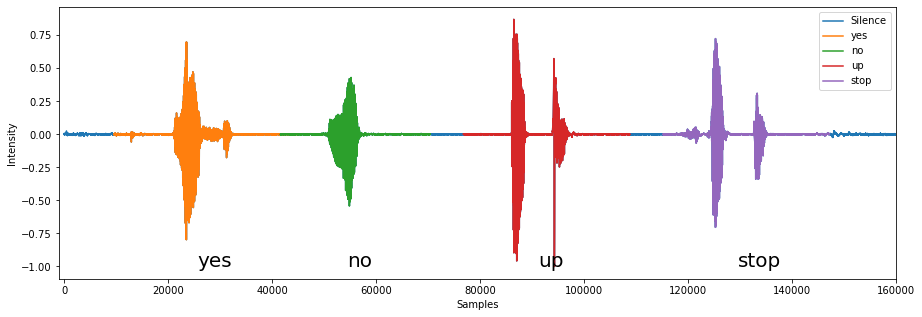

In [29]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(myrec,label="Silence")
plt.xlabel("Samples")
plt.ylabel("Intensity")
plt.xlim(-1000, len(myrec))



i=1
splitted=[]
chunk=[newPredictions[i]]
while i <len(newPredictions):
    if newPredictions[i]==newPredictions[i-1]:
        chunk.append(newPredictions[i])
    else:
        splitted.append(chunk)
        chunk=[newPredictions[i]]
    i+=1
splitted.append(chunk)


labels=[]
yaxis=[]
xaxis=[]
start=step
for j in range(len(splitted)):
    k=len(splitted[j])
    if splitted[j][0]!=-1:
        labels.append(categories[splitted[j][0]])
        yaxis.append(myrec[start:sr+start+step*(k-2)])
        xaxis.append(list(range(start,sr+start+step*(k-2))))
    start+=step*k


    
for i in range(len(yaxis)):
    plt.plot(xaxis[i],yaxis[i], label=labels[i])
    #plt.vlines(xaxis[i][0], np.min(myrec), np.max(myrec), colors='k',linestyles='dashed')
    #plt.vlines(xaxis[i][-1], np.min(myrec), np.max(myrec), colors='k',linestyles='dashed')
    plt.text(xaxis[i][0]-step//2+(xaxis[i][-1]-xaxis[i][0])//2, np.min(myrec), labels[i], color='k',fontsize=20)

plt.legend()
plt.show()